In [1]:
import os
import pandas as pd
import pickle
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf

import librosa
import librosa.display

from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from my_functions.my_fun import *
from my_functions.my_models import *
from my_functions.My_nn import My_nn

2024-09-13 17:10:04.175246: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-13 17:10:04.204300: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-13 17:10:04.204914: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-13 17:10:04.775221: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
load_dotenv()
ASSETS_DIR = os.getenv('ASSETS_DIR')

# Preparar las etiquetas

Cargar archivo de anotaciones y comprobar que existe

In [ ]:
anot = os.getenv('PMEMO_ANOTATIONS')
stat_anot_file = os.path.join(anot,'static_annotations.csv')

if os.path.exists(stat_anot_file):
    print("El archivo existe")
else:
    print("No hay no existe")
    
anotaciones_df = pd.read_csv(stat_anot_file)
anotaciones_df.head(5)

In [ ]:
labels = anotaciones_df[['Arousal(mean)','Valence(mean)']].values
print(labels)

# Preparar los espectrogramas

Cargar los espectrogramas ajustados

In [5]:
spectrograms = load_spectrograms(filename='spectrograms_down_padd')

In [ ]:
spectrograms = np.array(spectrograms)
print(type(spectrograms))
print(type(spectrograms[0]))
print(spectrograms[0].shape)

In [ ]:
spectrograms = np.expand_dims(spectrograms, axis=-1)
print(spectrograms.shape)
print(spectrograms[0].shape)

# Dividir los datos

In [8]:
#Entrenamiento y pruebas
X_train,X_test,y_train,y_test = train_test_split( spectrograms,
                                                 labels,
                                                 test_size=0.2,
                                                 random_state=83)
#Entrenamiento y validación
X_train,X_val, y_train,y_val =  train_test_split( X_train,
                                                  y_train,
                                                  test_size=0.2,
                                                  random_state=83)

# Normalizar?

In [ ]:
# Asumiendo que `spectrograms_array` es tu array de espectrogramas
print("Valor mínimo:", np.min(spectrograms))
print("Valor máximo:", np.max(spectrograms))
print("Media:", np.mean(spectrograms))
print("Desviación estándar:", np.std(spectrograms))

In [ ]:
# Aplana el array para facilitar la visualización
values = spectrograms.flatten()

plt.hist(values, bins=50)
plt.title('Histograma de Valores de Espectrogramas')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.show()

In [ ]:
# Obtener un resumen estadístico
stats = {
    'Mínimo': np.min(values),
    'Máximo': np.max(values),
    'Media': np.mean(values),
    'Desviación Estándar': np.std(values),
    '25º Percentil': np.percentile(values, 25),
    '50º Percentil (Mediana)': np.percentile(values, 50),
    '75º Percentil': np.percentile(values, 75)
}

for key, value in stats.items():
    print(f'{key}: {value}')

In [12]:
# Normalizar los datos
X_train_norm = X_train / np.max(X_train)
X_val_norm = X_val / np.max(X_val)
X_test_norm = X_test / np.max(X_test)

In [ ]:
# Graficar el espectrograma de la primer canción
aux_spec = np.squeeze(X_train[1])


#Visualizar
fig,ax = plt.subplots(figsize=(10,5))

img = librosa.display.specshow(aux_spec,
                               x_axis='time',
                               y_axis='log',
                               ax=ax)

ax.set_title('Espectrograma de la primer canción',fontsize=(20))
fig.colorbar(img,ax=ax,format=f'%0.2f')

plt.show()

In [ ]:
# Graficar el espectrograma de la primer canción pero normalizada
espectrograma_normalizado = np.squeeze(X_train_norm[1])
# Visualizar el espectrograma normalizado
fig,ax = plt.subplots(figsize=(10,5))

img = librosa.display.specshow(espectrograma_normalizado,
                               x_axis='time',
                               y_axis='log',
                               ax=ax)
ax.set_title('Espectrograma de la primer canción normalizada',fontsize=(20))
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

In [15]:
# Normalizar los datos
X_train = X_train_norm
X_val = X_val_norm
X_test = X_test_norm

# Guardar datos procesados

In [16]:
import h5py

In [17]:
# Guardar los datos en un archivo .h5
DATOS_DIR = os.path.join(ASSETS_DIR,'processed_data.h5')

with h5py.File(DATOS_DIR, 'w') as hf:
    hf.create_dataset('X_train', data=X_train)
    hf.create_dataset('X_test', data=X_test)
    hf.create_dataset('X_val', data=X_val)
    hf.create_dataset('y_train', data=y_train)
    hf.create_dataset('y_test', data=y_test)
    hf.create_dataset('y_val', data=y_val)

# Cargar datos procesados

In [3]:
import h5py
# Cargar los datos desde un archivo .h5
DATOS_DIR = os.path.join(ASSETS_DIR,'processed_data.h5')
with h5py.File(DATOS_DIR, 'r') as hf:
    X_train = hf['X_train'][:]
    X_test = hf['X_test'][:]
    X_val = hf['X_val'][:]
    y_train = hf['y_train'][:]
    y_test = hf['y_test'][:]
    y_val = hf['y_val'][:]

# CNN

In [4]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [5]:
print(f'--------------------ENTRENAMIENTO--------------------------------')
print(f'Dimensión datos de entrenamiento: {X_train.shape}')
print(f'Dimensión etiquetas de entrenamiento: {y_train.shape}')
print(f'--------------------PRUEBAS--------------------------------')
print(f'Dimensión datos de prueba: {X_test.shape}')
print(f'Dimensión etiquetas de prueba: {y_test.shape}')
print(f'--------------------VALIDACIÓN--------------------------------')
print(f'Dimensión datos de validación: {X_val.shape}')
print(f'Dimensión etiquetas de validación: {y_val.shape}')

--------------------ENTRENAMIENTO--------------------------------
Dimensión datos de entrenamiento: (490, 513, 1671, 1)
Dimensión etiquetas de entrenamiento: (490, 2)
--------------------PRUEBAS--------------------------------
Dimensión datos de prueba: (154, 513, 1671, 1)
Dimensión etiquetas de prueba: (154, 2)
--------------------VALIDACIÓN--------------------------------
Dimensión datos de validación: (123, 513, 1671, 1)
Dimensión etiquetas de validación: (123, 2)


In [6]:
modelo1 = modelo1()
primer_exp = My_nn(X_train=X_train,y_train=y_train,
                   X_test=X_test,y_test=y_test,
                   X_val=X_val,y_val=y_val,
                   model=modelo1)

2024-09-13 17:10:12.478886: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 436207616 exceeds 10% of free system memory.
2024-09-13 17:10:12.561320: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 436207616 exceeds 10% of free system memory.
2024-09-13 17:10:12.604523: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 436207616 exceeds 10% of free system memory.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 513, 1671, 1)]    0         
                                                                 
 conv2d (Conv2D)             (None, 513, 1671, 32)     320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 835, 32)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 256, 835, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 835, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 417, 64)     0     

/home/legokna/anaconda3/envs/mirtools/lib/python3.8/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


entrenar el modelo

In [7]:
hist =  primer_exp.train()

2024-09-13 17:10:13.242219: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1680157080 exceeds 10% of free system memory.


Epoch 1/20


2024-09-13 17:10:14.558690: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 436207616 exceeds 10% of free system memory.


31/31 [==============================] - 253s 8s/step - loss: 1737.1652 - mae: 25.7617 - val_loss: 9230572.0000 - val_mae: 2768.2854
Epoch 2/20
31/31 [==============================] - 247s 8s/step - loss: 132.7629 - mae: 8.0502 - val_loss: 850600.2500 - val_mae: 793.4436
Epoch 3/20
31/31 [==============================] - 247s 8s/step - loss: 27.6313 - mae: 3.1039 - val_loss: 82644.9141 - val_mae: 222.7468
Epoch 4/20
31/31 [==============================] - 246s 8s/step - loss: 3.6859 - mae: 1.0662 - val_loss: 4929.3350 - val_mae: 43.4747
Epoch 5/20
31/31 [==============================] - 247s 8s/step - loss: 5.9126 - mae: 0.9124 - val_loss: 84.5090 - val_mae: 3.8752
Epoch 6/20
31/31 [==============================] - 247s 8s/step - loss: 1.2242 - mae: 0.7277 - val_loss: 7.2851 - val_mae: 0.9188
Epoch 7/20
31/31 [==============================] - 247s 8s/step - loss: 1.2615 - mae: 0.6821 - val_loss: 6.1337 - val_mae: 0.8802
Epoch 8/20
31/31 [==============================] - 247s 8s/

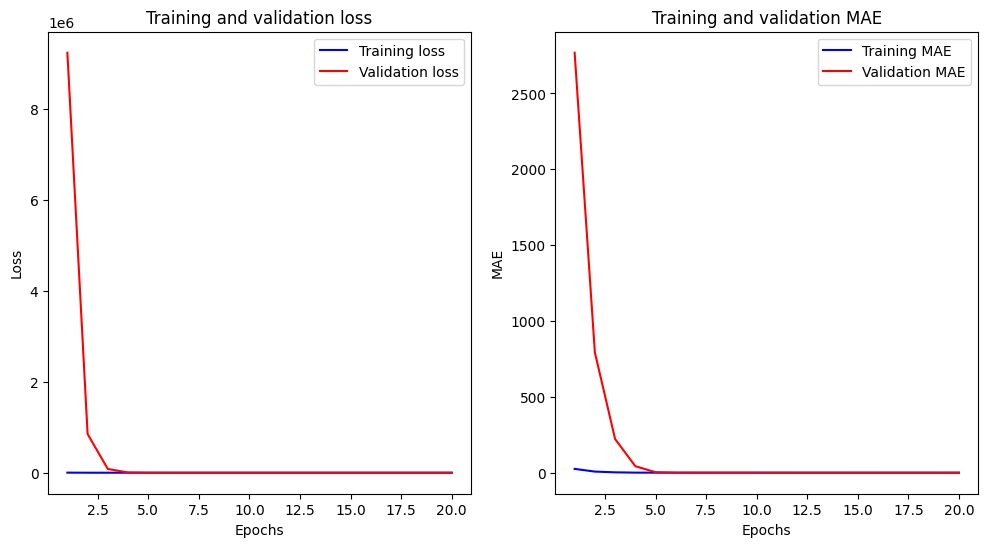

In [8]:
primer_exp.show_loss_history(hist)

In [9]:
loss,mae = primer_exp.evaluate()
print(loss)
print(mae)

5/5 - 15s - loss: 1.2175 - mae: 0.6043 - 15s/epoch - 3s/step
1.2175248861312866
0.6043494343757629


In [10]:
y_pred = primer_exp.recognize()
print(y_pred.shape)

5/5 [==============================] - 15s 3s/step
(154, 2)


In [14]:
reporte = primer_exp.get_report(y_true=y_test,y_pred=y_pred)
for k in reporte:
    print(f'{k}: {reporte[k]}')

Mean Squared Error (MSE): 1.2175248361171929
Mean Absolute Error (MAE): 0.6043494231816415
R-squared (R2): -1.369673467472575


In [24]:
print(np.sort(y_test))

[[0.3        0.3125    ]
 [0.675      0.8125    ]
 [0.6875     0.75      ]
 [0.47727273 0.52272727]
 [0.725      0.8125    ]
 [0.5875     0.6125    ]
 [0.6875     0.85      ]
 [0.6125     0.6625    ]
 [0.475      0.6625    ]
 [0.6125     0.65      ]
 [0.3        0.3125    ]
 [0.775      0.8875    ]
 [0.825      0.875     ]
 [0.425      0.4875    ]
 [0.575      0.7125    ]
 [0.6625     0.725     ]
 [0.825      0.8625    ]
 [0.55       0.55      ]
 [0.3875     0.575     ]
 [0.4375     0.4375    ]
 [0.425      0.55      ]
 [0.55       0.775     ]
 [0.4        0.675     ]
 [0.3125     0.7375    ]
 [0.5125     0.7625    ]
 [0.7625     0.7875    ]
 [0.35       0.5125    ]
 [0.6875     0.7       ]
 [0.575      0.6375    ]
 [0.1375     0.275     ]
 [0.5875     0.6625    ]
 [0.8        0.875     ]
 [0.8        0.9375    ]
 [0.8125     0.825     ]
 [0.45       0.475     ]
 [0.475      0.5625    ]
 [0.35       0.3875    ]
 [0.2875     0.375     ]
 [0.6125     0.625     ]
 [0.375      0.4375    ]


In [25]:
print(np.sort(y_pred))

[[  0.03285      0.07660567]
 [  0.15612404   0.21150833]
 [  0.03285      0.07660567]
 [  0.03285      0.07660567]
 [  0.03285      0.07660567]
 [  0.03285      0.07660567]
 [  0.03285      0.07660567]
 [  0.03285      0.07660567]
 [  0.13262515   0.19387048]
 [  0.05567284   0.136112  ]
 [  0.03285      0.07660567]
 [  0.03285      0.07660567]
 [  0.03285      0.07660567]
 [  0.03285      0.07660567]
 [  0.03285      0.07660567]
 [  0.09829836   0.16810602]
 [  0.03285      0.07660567]
 [  0.03285      0.07660567]
 [  3.1426973    8.545166  ]
 [  0.03285      0.07660567]
 [  0.03285      0.07660567]
 [  0.03285      0.07660567]
 [  0.03285      0.07660567]
 [  0.13262515   0.19387048]
 [  0.03285      0.07660567]
 [  0.03285      0.07660567]
 [  0.03285      0.07660567]
 [  0.03285      0.07660567]
 [  0.03285      0.07660567]
 [  0.03285      0.07660567]
 [  0.03285      0.07660567]
 [  0.37475163   0.37560505]
 [  0.46179336   0.4895807 ]
 [  0.03285      0.07660567]
 [  0.03285   

In [26]:
primer_exp.save_model()